In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

In [ ]:
data_df = pd.read_csv('Merged01.csv')
print(data_df.shape)
data_df.head()

(712311, 40)


,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,...,6421,60,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,...,57320,98,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,...,6010,60,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,...,2223,54,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,...,6006,60,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD


In [ ]:
# Verificar colunas com valores infinitos
inf_mask = data_df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float, np.number)) else False)

# Filtrar colunas com pelo menos um valor infinito
colunas_com_inf = inf_mask.any(axis=0)

# Exibir nomes das colunas com infinitos
print("Colunas com valores infinitos:")
print(colunas_com_inf[colunas_com_inf].index.tolist())

/tmp/ipython-input-3646384210.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  inf_mask = data_df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float, np.number)) else False)


Colunas com valores infinitos:
['Rate']


In [ ]:
# Criar máscara para linhas sem inf na coluna 'Rate'
mask = ~np.isinf(data_df['Rate'])

# Filtrar o DataFrame para remover linhas com inf
data_df = data_df[mask].reset_index(drop=True)

print(data_df.shape)

# Verificar colunas com valores infinitos
inf_mask = data_df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float, np.number)) else False)

# Filtrar colunas com pelo menos um valor infinito
colunas_com_inf = inf_mask.any(axis=0)

# Exibir nomes das colunas com infinitos
print("Colunas com valores infinitos:")
print(colunas_com_inf[colunas_com_inf].index.tolist())

(712297, 40)


/tmp/ipython-input-1782869003.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  inf_mask = data_df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float, np.number)) else False)


Colunas com valores infinitos:
[]


In [ ]:
attack_class_mapping = {
    # DDoS
    'DDOS-PSHACK_FLOOD': 'DDoS',
    'DDOS-ICMP_FLOOD': 'DDoS',
    'DDOS-TCP_FLOOD': 'DDoS',
    'DDOS-SYN_FLOOD': 'DDoS',
    'DDOS-UDP_FLOOD': 'DDoS',
    'DDOS-SYNONYMOUSIP_FLOOD': 'DDoS',
    'DDOS-RSTFINFLOOD': 'DDoS',
    'DDOS-SLOWLORIS': 'DDoS',
    'DDOS-ICMP_FRAGMENTATION': 'DDoS',
    'DDOS-ACK_FRAGMENTATION': 'DDoS',
    'DDOS-UDP_FRAGMENTATION': 'DDoS',
    'DDOS-HTTP_FLOOD': 'DDoS',

    # DoS
    'DOS-UDP_FLOOD': 'DoS',
    'DOS-TCP_FLOOD': 'DoS',
    'DOS-SYN_FLOOD': 'DoS',
    'DOS-HTTP_FLOOD': 'DoS',

    # Recon
    'RECON-HOSTDISCOVERY': 'Recon',
    'VULNERABILITYSCAN': 'Recon',
    'RECON-PORTSCAN': 'Recon',
    'RECON-OSSCAN': 'Recon',
    'RECON-PINGSWEEP': 'Recon',

    # Web-based
    'XSS': 'Web-based',
    'SQLINJECTION': 'Web-based',
    'COMMANDINJECTION': 'Web-based',
    'BACKDOOR_MALWARE': 'Web-based',
    'UPLOADING_ATTACK': 'Web-based',
    'BROWSERHIJACKING': 'Web-based',

    # Brute Force
    'DICTIONARYBRUTEFORCE': 'Brute Force',

    # Spoofing
    'DNS_SPOOFING': 'Spoofing',
    'MITM-ARPSPOOFING': 'Spoofing',

    # Mirai
    'MIRAI-GREIP_FLOOD': 'Mirai',
    'MIRAI-GREETH_FLOOD': 'Mirai',
    'MIRAI-UDPPLAIN': 'Mirai',

    # Benigno
    'BENIGN': 'BENIGN'
}

attack_class_to_num = {
    'BENIGN': 0,
    'DDoS': 1,
    'DoS': 2,
    'Recon': 3,
    'Web-based': 4,
    'Brute Force': 5,
    'Spoofing': 6,
    'Mirai': 7
}

In [ ]:
# Cria nova coluna com a classe textual
data_df['Attack_Type'] = data_df['Label'].map(attack_class_mapping)
data_df['Attack_Class'] = data_df['Attack_Type'].map(attack_class_to_num)
print("Distribuição de classes (absoluta)")
print(data_df['Attack_Class'].value_counts())
print("Distribuição de classes (percentual)")
print(data_df['Attack_Class'].value_counts(normalize=True) * 100)
data_df.head()

Distribuição de classes (absoluta)
Attack_Class
1    515113
2    122494
7     39661
0     16574
3     10562
6      7328
4       361
5       204
Name: count, dtype: int64
Distribuição de classes (percentual)
Attack_Class
1    72.317165
2    17.197040
7     5.568043
0     2.326838
3     1.482808
6     1.028784
4     0.050681
5     0.028640
Name: proportion, dtype: float64


,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Max,AVG,Std,Tot size,IAT,Number,Variance,Label,Attack_Type,Attack_Class
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,...,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD,DDoS,1
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,...,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD,Mirai,7
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,...,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD,DoS,2
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,...,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING,Spoofing,6
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,...,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD,DDoS,1


In [ ]:
# Separar X e y
X = data_df.drop(columns=['Label', 'Attack_Type', 'Attack_Class'])
y = data_df['Attack_Class']                 # coluna alvo

# 1º Split: Treino + Temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2º Split: Validação e Teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Converter para DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Resultado
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (498607, 39)
Val: (106845, 39)
Test: (106845, 39)


In [18]:
print("\n--- Simulação de Federated Learning ---")

# 1. Divisão do conjunto de treino em 4 clientes (silos de dados)
num_clients = 4
X_train_clients = np.array_split(X_train, num_clients)
y_train_clients = np.array_split(y_train, num_clients)
dtrain_clients = []

for i in range(num_clients):
    # Converter cada parte para DMatrix
    dtrain_clients.append(xgb.DMatrix(X_train_clients[i], label=y_train_clients[i]))
    print(f"Cliente {i+1} - Tamanho: {X_train_clients[i].shape}")

# dval e dtest permanecem os mesmos (usados para avaliação global)
# dval   = xgb.DMatrix(X_val, label=y_val)
# dtest  = xgb.DMatrix(X_test, label=y_test)

# Parâmetros
params = {
    'objective': 'multi:softprob',
    'num_class': 8,
    'eval_metric': 'mlogloss',
    'verbosity': 0, # Reduzindo verbosidade para o loop
    'eta': 0.05,     # Taxa de aprendizado
    'max_depth': 10
}

global_model = None
num_boost_round = 50  # Reduzido para simulação
rounds_per_client = 5  # Rounds de treino em cada cliente antes da 'agregação'


--- Simulação de Federated Learning ---


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Cliente 1 - Tamanho: (124652, 39)
Cliente 2 - Tamanho: (124652, 39)
Cliente 3 - Tamanho: (124652, 39)
Cliente 4 - Tamanho: (124651, 39)


`global_model	`

Significado:	É a variável que armazena a versão atual e agregada do modelo XGBoost.

Contexto FL: No FL, este é o modelo mantido pelo servidor central. O treinamento começa com None (ou um modelo inicial vazio), e a cada Round Global, ele é atualizado com o conhecimento agregado dos 4 clientes, sem que o servidor veja os dados brutos.

`num_boost_round`

Significado: Define o número total de árvores (ou iterações de boosting) que o modelo final deve ter.

Contexto FL: Este é o número total de rounds de treinamento se fosse um treinamento centralizado (como no seu código original). Na simulação de FL, é o número máximo de árvores que será construído de forma distribuída.

`rounds_per_client`

Significado: Define quantas iterações (rounds ou árvores) cada cliente treina localmente antes de retornar o resultado para o servidor.

Contexto FL: Isso define o passo de aprendizado local (o número de epochs locais).

## Resumo do Fluxo de Treinamento

Usando seus valores (`num_boost_round`=50, `rounds_per_client`=5):

Início: global_model está vazio.

Round Global 1:

1. Cliente 1 treina 5 árvores (a partir de global_model=None).
2. Cliente 2 treina 5 árvores (a partir do resultado do Cliente 1).
3. Cliente 3 treina 5 árvores (a partir do resultado do Cliente 2).
4. Cliente 4 treina 5 árvores (a partir do resultado do Cliente 3).

O global_model agora tem $4 \times 5 = 20$ árvores (Na sua simulação simplificada, o modelo global é o modelo do último cliente).

Round Global 2:
1. Cliente 1 treina mais 5 árvores (a partir do modelo global com 20 árvores).... e assim por diante...

Fim: O processo se repete por $\mathbf{10}$ Rounds Globais, totalizando as 50 árvores.

In [19]:
# Array para armazenar resultados de perda para o plot
evals_result_fl = {'train': {'mlogloss': []}, 'val': {'mlogloss': []}}

for global_round in range(int(num_boost_round / rounds_per_client)):
    print(f"\n===== Round Global {global_round + 1} de {int(num_boost_round / rounds_per_client)} =====")

    for i in range(num_clients):
        dclient = dtrain_clients[i]

        # Treinamento Local (Cliente i)
        # O modelo inicial é o modelo global anterior (ou None no primeiro round)

        # O modelo é atualizado localmente a partir do modelo global
        local_model = xgb.train(
            params,
            dclient,
            num_boost_round=rounds_per_client, # Apenas alguns rounds localmente
            xgb_model=global_model,          # Continua o treinamento a partir do modelo global
            evals=[(dclient, 'local_train')],
            verbose_eval=False
        )

        # Simulação de Agregação (Substitui o modelo global pelo último modelo treinado)
        # Em um FL real, o servidor agregaria pesos ou gradientes/hessianos.
        # Aqui, estamos simulando a atualização do modelo global.
        global_model = local_model
        print(f"  -> Cliente {i+1} treinado. Modelo Global Atualizado.")

    # Avaliação do Modelo Global no conjunto de Validação após a rodada global
    # Isso simula o Servidor avaliando o modelo agregado.
    eval_mlogloss_val = global_model.eval(dval, 'val_eval').split('\t')[1].split(':')[1]
    eval_mlogloss_train = global_model.eval(dtrain_clients[0], 'train_eval').split('\t')[1].split(':')[1] # Apenas no Cliente 1 para simplificar o plot

    print(f"  ** Loss de Validação Global: {eval_mlogloss_val}")

    # Armazenar resultados para plot (apenas uma entrada por round global)
    evals_result_fl['train']['mlogloss'].extend([float(eval_mlogloss_train)] * rounds_per_client)
    evals_result_fl['val']['mlogloss'].extend([float(eval_mlogloss_val)] * rounds_per_client)

# O modelo final treinado é o `global_model`
final_model = global_model
print("\n✅ Treinamento Federado Concluído.")


===== Round Global 1 de 10 =====
  -> Cliente 1 treinado. Modelo Global Atualizado.
  -> Cliente 2 treinado. Modelo Global Atualizado.
  -> Cliente 3 treinado. Modelo Global Atualizado.
  -> Cliente 4 treinado. Modelo Global Atualizado.
  ** Loss de Validação Global: 0.75286950551664111

===== Round Global 2 de 10 =====
  -> Cliente 1 treinado. Modelo Global Atualizado.
  -> Cliente 2 treinado. Modelo Global Atualizado.
  -> Cliente 3 treinado. Modelo Global Atualizado.
  -> Cliente 4 treinado. Modelo Global Atualizado.
  ** Loss de Validação Global: 0.48535862322719775

===== Round Global 3 de 10 =====
  -> Cliente 1 treinado. Modelo Global Atualizado.
  -> Cliente 2 treinado. Modelo Global Atualizado.
  -> Cliente 3 treinado. Modelo Global Atualizado.
  -> Cliente 4 treinado. Modelo Global Atualizado.
  ** Loss de Validação Global: 0.38305487564946961

===== Round Global 4 de 10 =====
  -> Cliente 1 treinado. Modelo Global Atualizado.
  -> Cliente 2 treinado. Modelo Global Atualizad

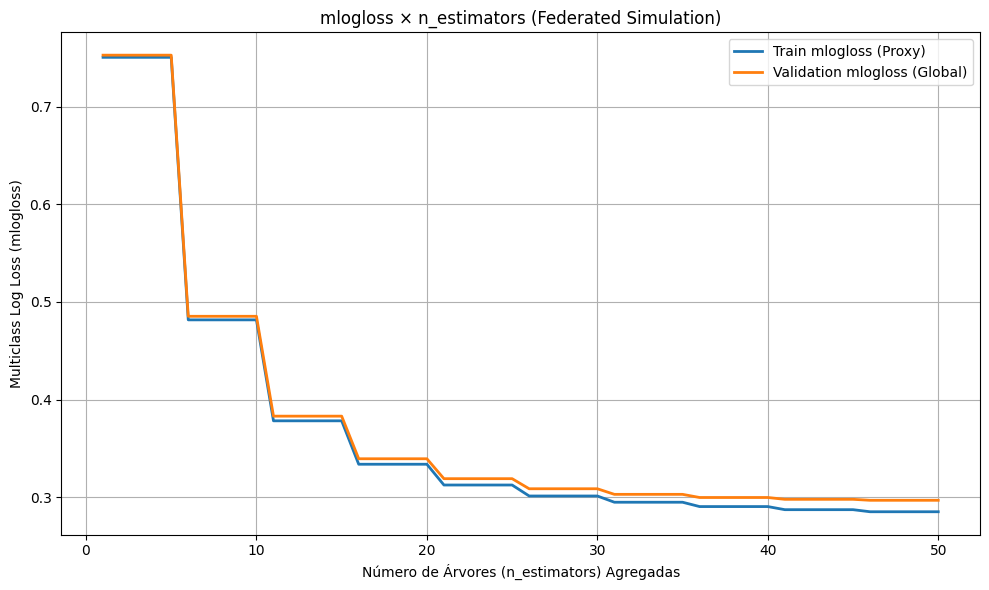


--- Avaliação do Modelo Global ---
📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84      2486
         1.0       0.86      0.97      0.91     77267
         2.0       0.72      0.35      0.47     18374
         3.0       0.76      0.75      0.75      1584
         4.0       0.33      0.04      0.07        54
         5.0       0.80      0.13      0.22        31
         6.0       0.92      0.84      0.88      1100
         7.0       1.00      0.99      1.00      5949

    accuracy                           0.86    106845
   macro avg       0.77      0.62      0.64    106845
weighted avg       0.84      0.86      0.84    106845

✅ Accuracy: 0.8553231316392905


<Figure size 1000x800 with 0 Axes>

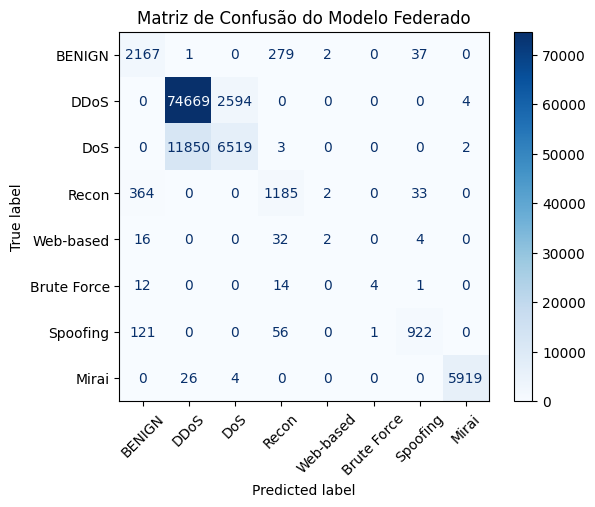

In [20]:
# Plotar mlogloss vs n_estimators
# Ajustamos o array de rounds para refletir o número total de rounds no modelo final
total_rounds = len(evals_result_fl['val']['mlogloss'])
rounds = list(range(1, total_rounds + 1))

plt.figure(figsize=(10, 6))
# Usamos o resultado do primeiro cliente como proxy para 'train'
plt.plot(rounds, evals_result_fl['train']['mlogloss'], label='Train mlogloss (Proxy)', linewidth=2)
plt.plot(rounds, evals_result_fl['val']['mlogloss'], label='Validation mlogloss (Global)', linewidth=2)
plt.xlabel('Número de Árvores (n_estimators) Agregadas')
plt.ylabel('Multiclass Log Loss (mlogloss)')
plt.title('mlogloss × n_estimators (Federated Simulation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Previsões em forma de probabilidade
y_pred_prob = final_model.predict(dtest)

# Converter para rótulos (classe com maior probabilidade)
y_pred = np.argmax(y_pred_prob, axis=1)

# Valores reais
y_true = dtest.get_label()

print("\n--- Avaliação do Modelo Global ---")
print("📊 Classification Report:")
# Certifique-se de que `y_true` e `y_pred` são válidos
print(classification_report(y_true, y_pred))

print("✅ Accuracy:", accuracy_score(y_true, y_pred))

# Gerar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(attack_class_to_num.keys()))

# Plotar a imagem
plt.figure(figsize=(10,8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão do Modelo Federado')
plt.show()